In [ ]:
# Install TensorFlow and TensorFlow Datasets
!pip install tensorflow tensorflow-datasets

# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Load the Oxford-IIIT Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.4MXGXS_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.4MXGXS_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmp9bxwmm11tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel

In [ ]:
# Number of classes to predict (MULTI-CLASS CLASSIFICATION for 37 classes)
info.features['label'].num_classes

37

In [ ]:
class_names = info.features['label'].int2str
print(class_names)

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=int64, num_classes=37)>


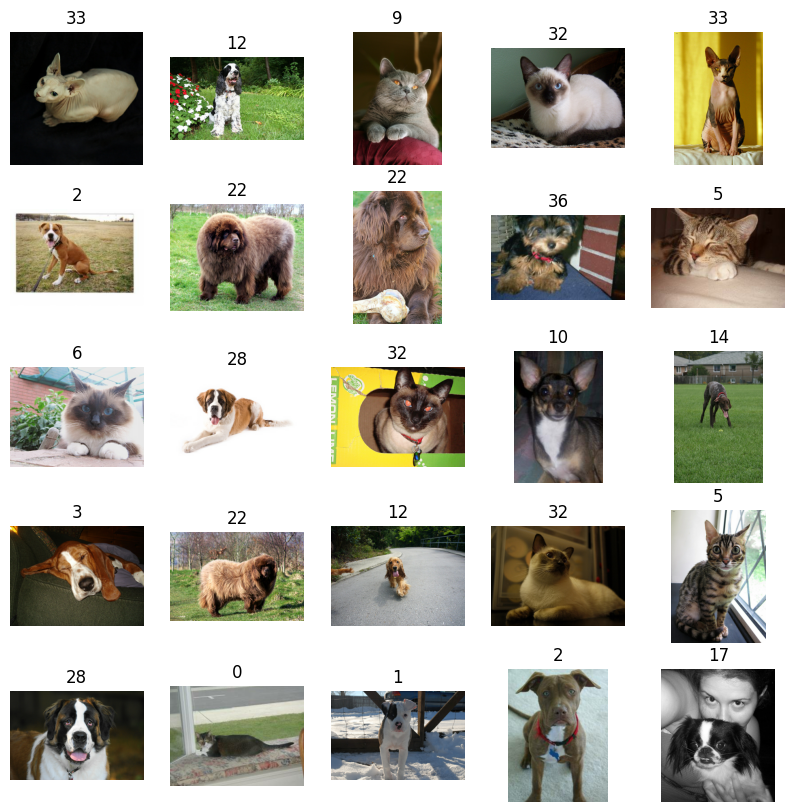

In [ ]:
# Function to plot images from the dataset
def plot_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy())
        plt.title(int(label))
        plt.axis('off')
    plt.show()

# Plot 25 images from the dataset
plot_images(dataset['train'], 25)


In [ ]:
# Function to preprocess images
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing
train_data = dataset['train'].map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = dataset['test'].map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

# Function to convert tf.data.Dataset to numpy arrays
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.stack(images), np.stack(labels)

# Convert the train and test datasets to numpy arrays
train_images, train_labels = [], []
for images, labels in train_data:
    img, lbl = dataset_to_numpy(tf.data.Dataset.from_tensor_slices((images, labels)))
    train_images.append(img)
    train_labels.append(lbl)
train_images = np.concatenate(train_images, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

test_images, test_labels = [], []
for images, labels in test_data:
    img, lbl = dataset_to_numpy(tf.data.Dataset.from_tensor_slices((images, labels)))
    test_images.append(img)
    test_labels.append(lbl)
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment the training data using ImageDataGenerator
augmented_train_data = datagen.flow(train_images, train_labels, batch_size=32)

In [ ]:
# Load pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add classification head
model = tf.keras.Sequential([

    tf.keras.layers.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(37, activation='softmax')  # 37 classes in the dataset
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 37)                4773      
                                                           

In [ ]:
# Train the model
history = model.fit(augmented_train_data, validation_data=test_data, epochs=6)

Epoch 1/6
115/115 [==============================] - 70s 585ms/step - loss: 1.2454 - accuracy: 0.6707 - val_loss: 0.5522 - val_accuracy: 0.8160
Epoch 2/6
115/115 [==============================] - 67s 587ms/step - loss: 0.5281 - accuracy: 0.8245 - val_loss: 0.4705 - val_accuracy: 0.8471
Epoch 3/6
115/115 [==============================] - 67s 583ms/step - loss: 0.4276 - accuracy: 0.8592 - val_loss: 0.5113 - val_accuracy: 0.8452
Epoch 4/6
115/115 [==============================] - 67s 584ms/step - loss: 0.3388 - accuracy: 0.8954 - val_loss: 0.4818 - val_accuracy: 0.8509
Epoch 5/6
115/115 [==============================] - 66s 574ms/step - loss: 0.3100 - accuracy: 0.8970 - val_loss: 0.5418 - val_accuracy: 0.8392
Epoch 6/6
115/115 [==============================] - 66s 577ms/step - loss: 0.2685 - accuracy: 0.9095 - val_loss: 0.4873 - val_accuracy: 0.8485


In [ ]:
# Fine-tune the model
base_model.trainable = True

# Freeze early layers if needed (optional)
for layer in base_model.layers[:100]: # Example: Freeze first 100 layers
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy', # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 37)                4773      
                                                                 
Total params: 2426725 (9.26 MB)
Trainable params: 203018

In [ ]:
# Predict on the test data
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

115/115 [==============================] - 24s 196ms/step


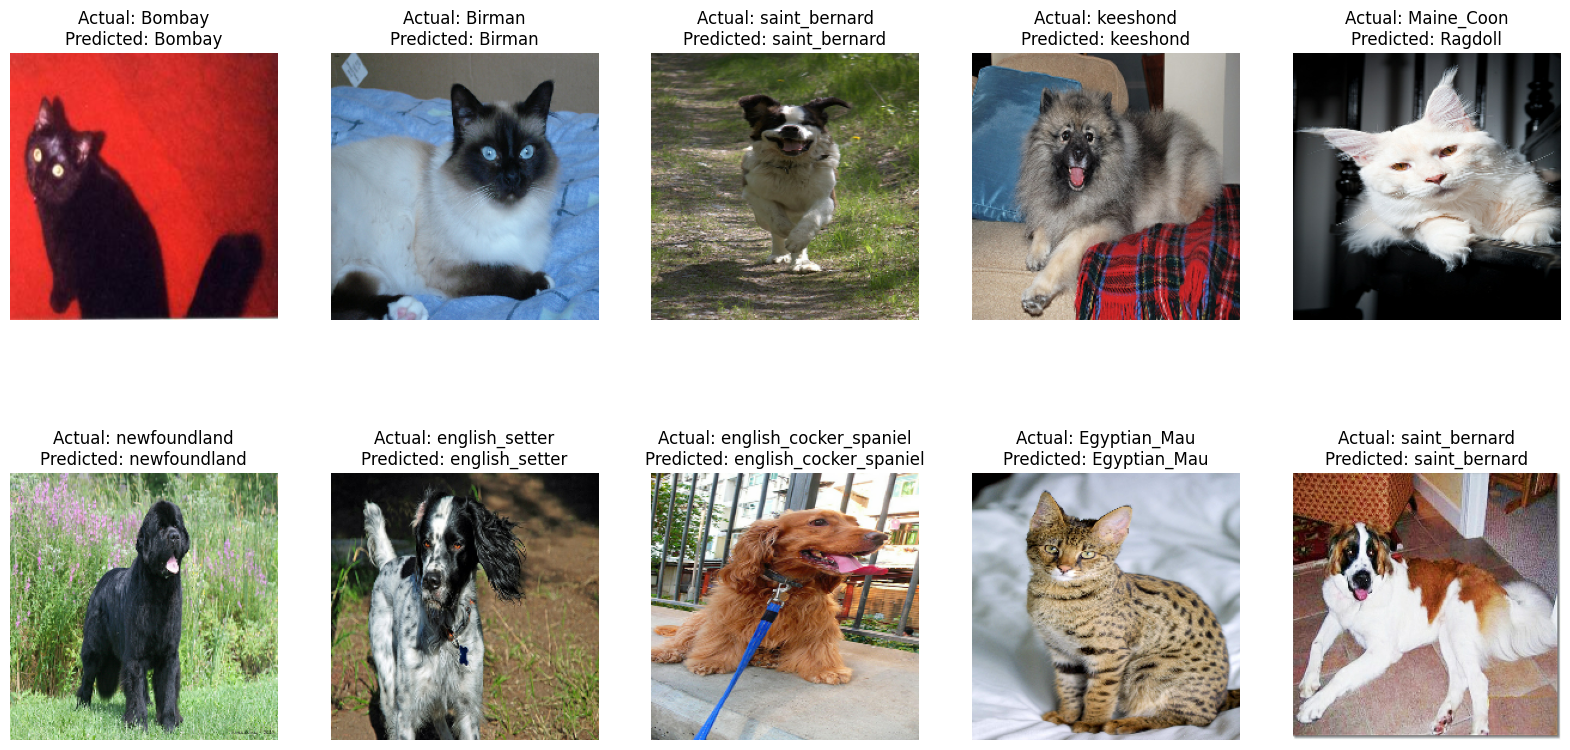

In [ ]:
import random
# Function to plot random actual vs predicted classes
def plot_random_actual_vs_predicted(images, actual, predicted, class_names, num=10):
    indices = random.sample(range(len(images)), num)
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, num // 2, i + 1)
        plt.imshow(images[idx])
        plt.title(f'Actual: {class_names(actual[idx])}\nPredicted: {class_names(predicted[idx])}')
        plt.axis('off')
    plt.show()

# Get class names
class_names = info.features['label'].int2str

# Show random actual and predicted classes
plot_random_actual_vs_predicted(test_images, test_labels, test_predictions_classes, class_names, num=10)

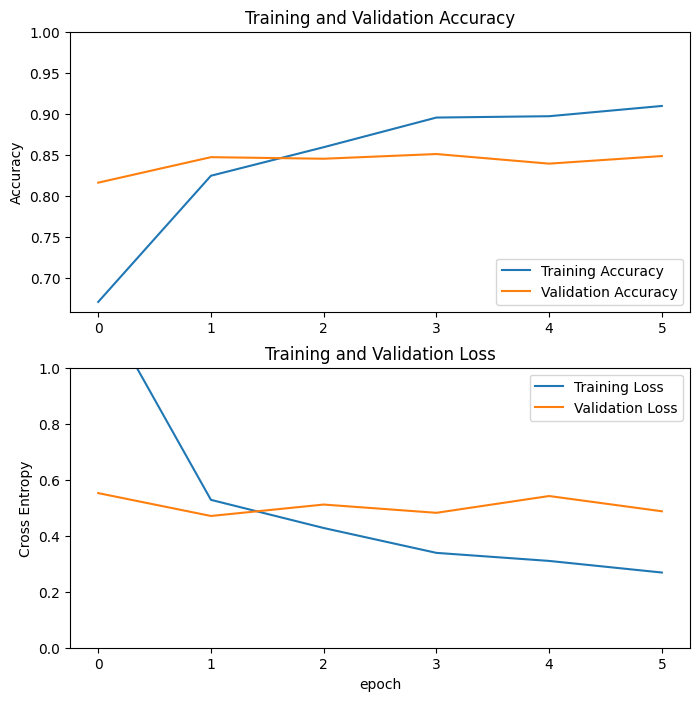

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Using NASNetMobile Model**

In [ ]:
# Load pre-trained NASNetMobile model
base_model = tf.keras.applications.NASNetMobile(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add classification head
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(37, activation='softmax')  # 37 classes in the dataset
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

19993432/19993432 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d_1  (None, 1056)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               135296    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 37)                4773      
                                                                 
Total params: 4409785 (16.82 MB)
Trainable params: 1400

In [ ]:
# Train the model
history = model.fit(augmented_train_data, validation_data=test_data, epochs=6)

Epoch 1/6
115/115 [==============================] - 80s 591ms/step - loss: 1.1518 - accuracy: 0.6967 - val_loss: 0.4460 - val_accuracy: 0.8596
Epoch 2/6
115/115 [==============================] - 64s 556ms/step - loss: 0.4586 - accuracy: 0.8516 - val_loss: 0.4160 - val_accuracy: 0.8610
Epoch 3/6
115/115 [==============================] - 63s 550ms/step - loss: 0.4096 - accuracy: 0.8592 - val_loss: 0.3712 - val_accuracy: 0.8703
Epoch 4/6
115/115 [==============================] - 63s 550ms/step - loss: 0.3633 - accuracy: 0.8799 - val_loss: 0.3452 - val_accuracy: 0.8902
Epoch 5/6
115/115 [==============================] - 62s 543ms/step - loss: 0.3212 - accuracy: 0.8929 - val_loss: 0.4091 - val_accuracy: 0.8635
Epoch 6/6
115/115 [==============================] - 62s 544ms/step - loss: 0.3076 - accuracy: 0.8967 - val_loss: 0.3692 - val_accuracy: 0.8744


In [ ]:
# Fine-tune the model
base_model.trainable = True

# Freeze early layers if needed (optional)
for layer in base_model.layers[:100]: # Example: Freeze first 100 layers
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy', # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d_1  (None, 1056)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               135296    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 37)                4773      
                                                                 
Total params: 4409785 (16.82 MB)
Trainable params: 4349725 (16.59 MB)
Non-trainable params: 60060 (234.61 KB)
__________

In [ ]:
# Predict on the test data
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

115/115 [==============================] - 23s 168ms/step


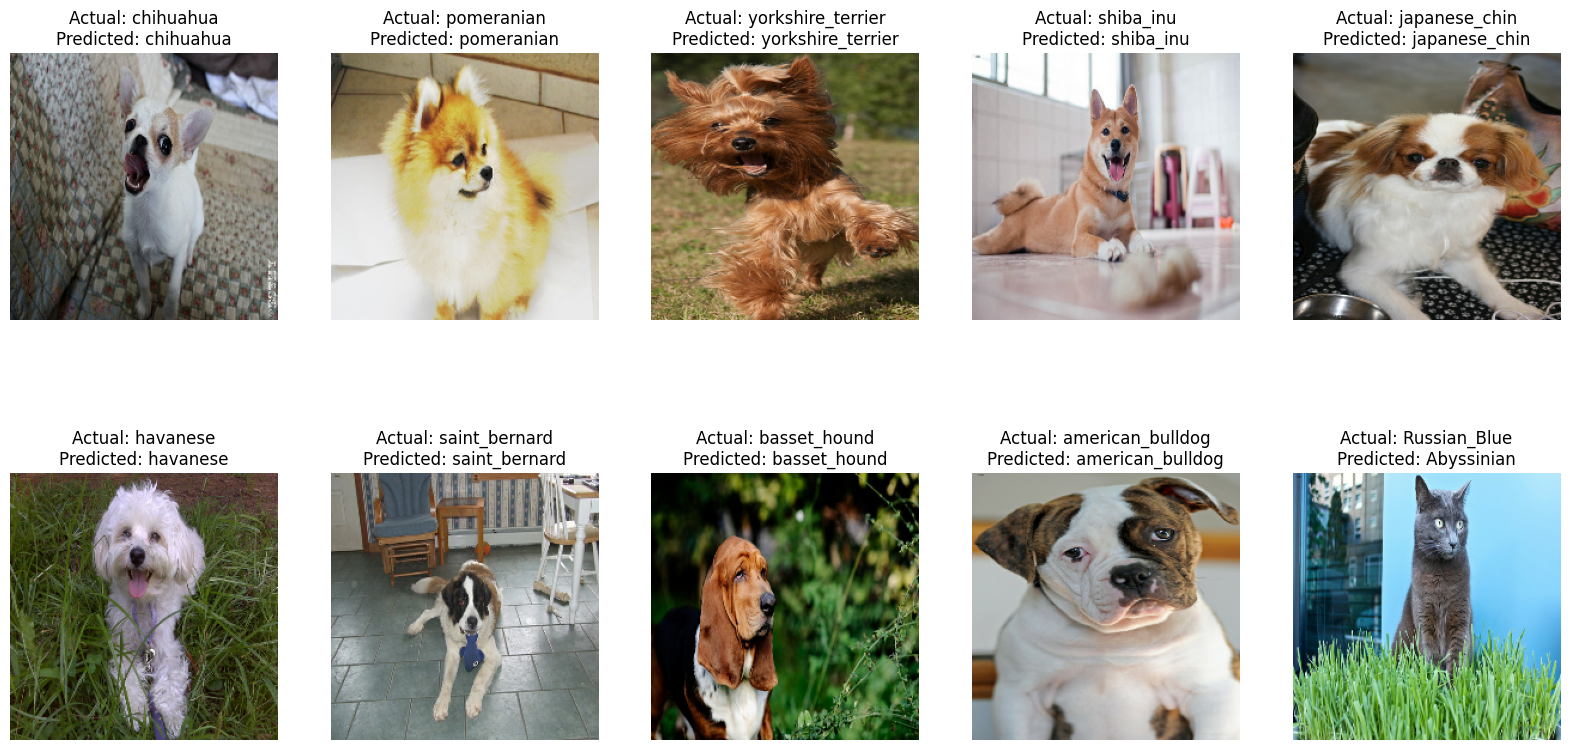

In [ ]:
import random
# Function to plot random actual vs predicted classes
def plot_random_actual_vs_predicted(images, actual, predicted, class_names, num=10):
    indices = random.sample(range(len(images)), num)
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, num // 2, i + 1)
        plt.imshow(images[idx])
        plt.title(f'Actual: {class_names(actual[idx])}\nPredicted: {class_names(predicted[idx])}')
        plt.axis('off')
    plt.show()

# Get class names
class_names = info.features['label'].int2str

# Show random actual and predicted classes
plot_random_actual_vs_predicted(test_images, test_labels, test_predictions_classes, class_names, num=10)


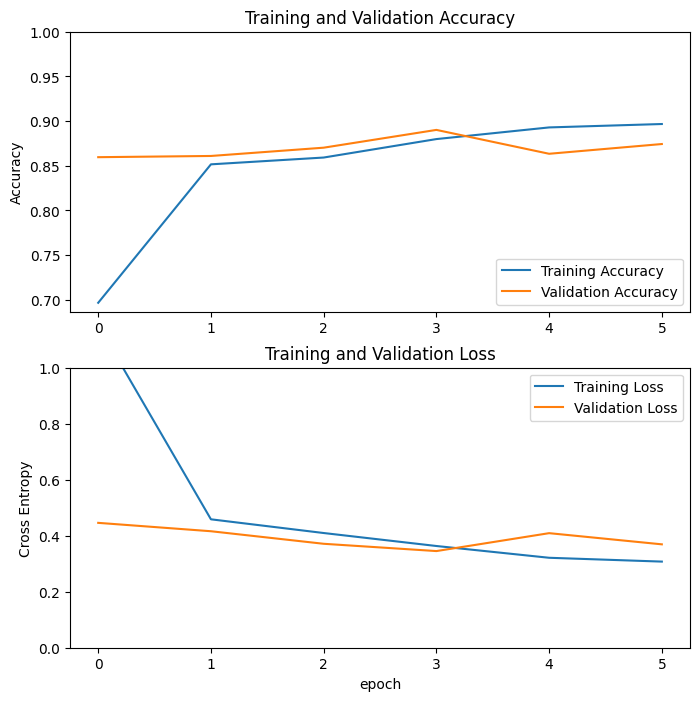

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()